# Original notebook:
https://www.kaggle.com/code/takanashihumbert/cibmtr-using-official-metric-in-tree-based-models/notebook

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
import os, glob, math, gc, warnings, random, joblib
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("we are using xgboost ==", xgb.__version__)
from lightgbm import LGBMRegressor, callback

from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import pdb

we are using xgboost == 2.1.3


In [2]:
class ParticipantVisibleError(Exception):
    pass


def custom_score(solution, submission, row_id_column_name, prediction_label='prediction', print_info=True):
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_dict = {}
    for race in sorted(merged_df_race_dict.keys()):
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])

        metric_dict[race] = c_index_race

    race_c_index = list(metric_dict.values())
    c_score = float(np.mean(race_c_index) - np.std(race_c_index))
    if print_info:
        print(f"{Fore.GREEN}{Style.BRIGHT}# c-index={c_score:.4f}, mean={np.mean(race_c_index):.4f} std={np.std(race_c_index):.4f}{Style.RESET_ALL}")
    
    return c_score, metric_dict


def display_overall(df):
    
    race_groups = [
        'American Indian or Alaska Native', 'Asian',
       'Black or African-American', 'More than one race',
       'Native Hawaiian or other Pacific Islander', 'White'
    ]
    df['mean'] = df[race_groups].mean(axis=1)
    df['std'] = np.std(df[race_groups], axis=1)
    df['score'] = df['mean'] - df['std']
    df = df.T
    df['Overall'] = df.mean(axis=1)
    temp = df.drop(index=['std']).values
    display(df
            .iloc[:len(race_groups)]
            .style
            .format(precision=4)
            .background_gradient(axis=None, vmin=temp.min(), vmax=temp.max(), cmap="cool")
            .concat(df.iloc[len(race_groups):].style.format(precision=3))
           )


# Load Train and Test

In [3]:
test = pd.read_csv("../preprocessed_data/custom_test_0.1_imbalanced.csv")
print("Test shape:", test.shape )

test_balanced = pd.read_csv("../preprocessed_data/custom_test_0.1_balanced.csv")
print("Balanced Test shape:", test_balanced.shape )

train = pd.read_csv("../preprocessed_data/custom_train_0.9_balanced.csv")
print("Train shape:",train.shape)

Test shape: (1057, 60)
Balanced Test shape: (2880, 60)
Train shape: (25920, 60)


In [4]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    """
    Transform using survival probability estimates
    """
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    
    return y

# Let's substract 0.1 instead of 0.2 from the Kaplan Meier survival scores 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


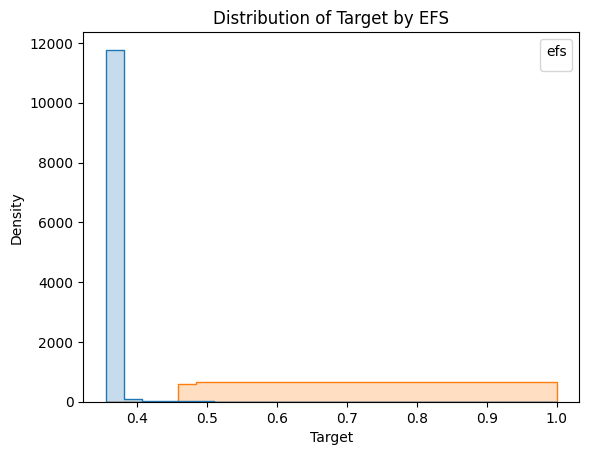

In [5]:
SUBTRACT_KP_SCORE = 0.1

train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook

test['label'] = transform_survival_probability(test, time_col='efs_time', event_col='efs')
test.loc[test['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook
test_balanced['label'] = transform_survival_probability(test_balanced, time_col='efs_time', event_col='efs')
test_balanced.loc[test_balanced['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook

sns.histplot(data=train, x='label', hue='efs', element='step', common_norm=False)
plt.legend(title='efs')
plt.title('Distribution of Target by EFS')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

# Let's convert year_hct to year_hct_from_baseline to avoid a big difference in scale

In [6]:
MIN_YEAR = train['year_hct'].min() # 2008
train['year_hct_relative'] = train['year_hct'] - MIN_YEAR
train.drop(columns=['year_hct'], inplace=True)

test['year_hct_relative'] = test['year_hct'] - MIN_YEAR
test.drop(columns=['year_hct'], inplace=True)   

test_balanced['year_hct_relative'] = test_balanced['year_hct'] - MIN_YEAR   
test_balanced.drop(columns=['year_hct'], inplace=True)  


In [7]:
RMV = ["ID","efs","efs_time","label",'y','kfold']
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'year_hct_relative']


In [8]:
CAT_FEATURES = []
for c in FEATURES:
    if train[c].dtype=="object":
        CAT_FEATURES.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        test_balanced[c] = test_balanced[c].fillna("NAN")

In [9]:
combined = pd.concat([train, test, test_balanced], axis=0, ignore_index=True)

print("The CATEGORICAL FEATURES: ", end="")
for c in FEATURES:
    if c in CAT_FEATURES:
        print(f"{c}, ", end="")
        combined[c] = combined[c].astype("category")
    else:
        if combined[c].dtype == "float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype == "int64":
            combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):len(train) + len(test)].reset_index(drop=True).copy()
test_balanced = combined.iloc[len(train) + len(test):].reset_index(drop=True).copy()


The CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [10]:
folds = 5
train['kfold'] = -1  

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(skf.split(X=train, y=groups)):
    train.loc[val_idx, 'kfold'] = fold

# Custom Metrics

In [11]:
def CIndexMetric_XGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return -cindex_score

def CIndexMetric_LGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return ('C-Index', cindex_score, True)

# Importance weighting

In [12]:
TARGET_PROPS = {
    'White': 0.8,
    'Black or African-American': 0.09,
    'Asian': 0.04,
    'Native Hawaiian or other Pacific Islander': 0.02,
    'American Indian or Alaska Native': 0.03,
    'More than one race': 0.02
}

# Calculate importance weights once before training
train_props = {group: 1/len(TARGET_PROPS) for group in TARGET_PROPS}  # Balanced training
importance_weights = (
    train['race_group']
    .map(lambda g: TARGET_PROPS[g] / train_props[g])
    .astype(float)
    .values
)


# DeepSeek's adversarial training for group invariance and group DPO

In [14]:
# Prepare out‑of‑fold DataFrame to hold predictions and metadata
oof_xgb = train[['kfold', 'ID', 'efs', 'efs_time', 'label', 'race_group']].copy()
oof_xgb['prediction'] = 0.0
feature_importances_xgb = pd.DataFrame({'feature': FEATURES})
metric_df = []

# Add these parameters at the top
N_ITERATIONS = 3  # Number of adversarial+DRO updates
ADVERSARY_STRENGTH = 0.7  # Higher = more race invariance
DRO_STRENGTH = 0.3  # Higher = more focus on worst groups

# Initialize sample weights and group weights
sample_weights = np.ones(len(train))
group_weights = {group: 1.0 for group in train['race_group'].unique()}

# Modified training loop with adversarial+DRO
for iteration in range(N_ITERATIONS):
    print(f"\n=== Adversarial+DRO Iteration {iteration+1}/{N_ITERATIONS} ===")
    
    oof_xgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
    oof_xgb['prediction'] = 0.0
    metric_df = []
    
    # Store adversary training data across folds
    all_train_indices = []  # Store indices of training data for each fold
    all_leaf_indices = []
    all_races = []
    
    for fold in range(skf.n_splits):
        print(f"\nFold {fold+1}/{skf.n_splits}")
        
        x_train = train[train.kfold != fold].copy()
        x_valid = train[train.kfold == fold].copy()

        y_train = x_train['label']
        y_valid = x_valid['label']

        # Store training indices for this fold
        all_train_indices.append(x_train.index)
        
        # define two extra dataframe for the custom metric
        ds_true = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
        ds_pred = oof_xgb.loc[oof_xgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)
        
        # Get current sample weights for training data
        train_weights = sample_weights[x_train.index]

        # Train model with current weights
        clf = XGBRegressor(
            tree_method="hist",
            max_depth=3,
            colsample_bytree=0.5, 
            subsample=0.8, 
            n_estimators=10000,  
            learning_rate=0.03,
            early_stopping_rounds=100,
            objective='reg:squarederror',
            enable_categorical=True,
            min_child_weight=5,
            eval_metric=CIndexMetric_XGB,
            disable_default_eval_metric=True
        )
        
        clf.fit(
            x_train[FEATURES], y_train,
            sample_weight=train_weights,  # Apply current weights
            eval_set=[(x_valid[FEATURES], y_valid)],
            verbose=500
        )
        
        # Get leaf indices for adversarial training
        # booster = clf.get_booster()
        num_trees = 1100 if iteration == 0 else 450 #booster.best_iteration
        leaf_indices = clf.get_booster().predict(
            xgb.DMatrix(x_train[FEATURES], enable_categorical=True),
            pred_leaf=True,
            iteration_range=(0, num_trees)  # Limit to the best number of trees
        )
        all_leaf_indices.append(leaf_indices)
        all_races.append(x_train['race_group'])
        
        # Store predictions
        preds_valid = clf.predict(x_valid[FEATURES])
        oof_xgb.loc[oof_xgb.kfold==fold, 'prediction'] = preds_valid
        
        clf.save_model(f"xgb/xgb_model_deepseek_imp_weighting_{iteration}_{fold}.bin")

        # Calculate fold metrics
        y_true = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy()
        y_pred = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","prediction"]].copy()
        _, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
        metric_df.append(metric_dict)
    
    # After all folds: Update weights -------------------------------------------------
    
    # 1. Adversarial weight update
    # Train adversary on leaf indices from all folds
    adversary = XGBClassifier(
        tree_method='hist',
        max_depth=3,
        enable_categorical=True,
        n_estimators=200
    )
    
    # Prepare adversarial training data
    adv_features = np.concatenate(all_leaf_indices)
    adv_target = pd.concat(all_races).reset_index(drop=True)
    
    # Encode race labels into numeric values
    label_encoder = LabelEncoder()
    adv_target_encoded = label_encoder.fit_transform(adv_target)

    # Train race predictor
    adversary.fit(adv_features, adv_target_encoded)

    adversary.save_model(f"xgb/xgb_model_deepseek_adversary_imp_weight_{iteration}.bin")
    
    # Calculate race predictability
    race_probs = adversary.predict_proba(adv_features)
    correct_probs = race_probs[np.arange(len(adv_target)), adv_target.cat.codes]
    adv_weights = 1 / (correct_probs + 1e-8)  # Downweight predictable samples
    
    # Map back to original indices
    adv_weight_df = pd.DataFrame({
        'index': np.concatenate(all_train_indices),  # Use stored training indices
        'adv_weight': adv_weights
    })
    adv_weight_df = (
    adv_weight_df
    .groupby('index')['adv_weight'].mean()  # Aggregate duplicates (mean/sum)
    .reindex(train.index)                   # Align with original training data
    .fillna(1.0)                            # Fill missing values
    .rename('adv_weight')                   # Rename for clarity
    .to_frame()                             # Convert to DataFrame
    )


    # 2. Group DRO weight update
    # Calculate group performance from OOF predictions
    group_cindex = {}
    for group in train['race_group'].unique():
        mask = (oof_xgb['race_group'] == group)
        if mask.sum() > 0:
            cidx = concordance_index(
                oof_xgb.loc[mask, 'efs_time'],
                -oof_xgb.loc[mask, 'prediction'],
                oof_xgb.loc[mask, 'efs']
            )
            group_cindex[group] = cidx
    
    # Calculate group weights inversely proportional to performance
    min_cindex = min(group_cindex.values())
    group_weights = {
        group: (min_cindex / (cidx + 1e-8)) * DRO_STRENGTH
        for group, cidx in group_cindex.items()
    }
    
    # 3. Combine weights
    # After computing adversarial and Group DRO weights, add importance weighting
    sample_weights = (
        (adv_weight_df['adv_weight'].values * ADVERSARY_STRENGTH) +
        (train['race_group'].map(group_weights).astype(float) * DRO_STRENGTH)
    ) * importance_weights  # Importance weighting multiplied in
    
    # Normalize weights with stability term
    sample_weights = sample_weights / (sample_weights.mean() + 1e-8)
    
    # Clip extreme weights to prevent instability
    sample_weights = np.clip(sample_weights, 0.1, 10)

# Final training with updated weights -------------------------------------------------
print("\n=== Final Training ===")
display_overall(pd.DataFrame(metric_df))



=== Adversarial+DRO Iteration 1/3 ===

Fold 1/5
[0]	validation_0-CIndexMetric_XGB:-0.58985
[500]	validation_0-CIndexMetric_XGB:-0.66653
[1000]	validation_0-CIndexMetric_XGB:-0.67204
[1500]	validation_0-CIndexMetric_XGB:-0.67362
[1758]	validation_0-CIndexMetric_XGB:-0.67431
# c-index=0.6745, mean=0.6877 std=0.0132

Fold 2/5
[0]	validation_0-CIndexMetric_XGB:-0.59093
[500]	validation_0-CIndexMetric_XGB:-0.66864
[1000]	validation_0-CIndexMetric_XGB:-0.67375
[1491]	validation_0-CIndexMetric_XGB:-0.67513
# c-index=0.6753, mean=0.6900 std=0.0147

Fold 3/5
[0]	validation_0-CIndexMetric_XGB:-0.59818
[500]	validation_0-CIndexMetric_XGB:-0.67604
[1000]	validation_0-CIndexMetric_XGB:-0.67916
[1171]	validation_0-CIndexMetric_XGB:-0.67900
# c-index=0.6793, mean=0.6846 std=0.0053

Fold 4/5
[0]	validation_0-CIndexMetric_XGB:-0.59214
[500]	validation_0-CIndexMetric_XGB:-0.66454
[1000]	validation_0-CIndexMetric_XGB:-0.66933
[1219]	validation_0-CIndexMetric_XGB:-0.67041
# c-index=0.6704, mean=0.6818 st

In [15]:
sample_weights

0        0.215407
1        0.583820
2        0.125864
3        0.312566
4        0.202808
           ...   
25915    3.001743
25916    0.337267
25917    0.532975
25918    0.118399
25919    3.019196
Name: race_group, Length: 25920, dtype: float64

In [18]:
def evaluate_adversarial_dro_models(test_df, model_prefix, adversary_prefix, 
                                   FEATURES, skf, custom_score, 
                                   n_iterations=3, dataset_name="Test Set"):
    """
    Evaluate adversarial+DRO trained models on test data
    Handles both fold-level models and adversaries from multiple iterations
    """
    print(f"\n{Fore.CYAN}=== Evaluating on {dataset_name} ==={Style.RESET_ALL}")
    
    # Initialize storage
    test_df = test_df.copy()
    all_metrics = {}
    dtest = xgb.DMatrix(test_df[FEATURES], enable_categorical=True)
    
    # Create containers for predictions
    iteration_ensemble_preds = np.zeros((len(test_df), n_iterations))
    
    for iteration in range(n_iterations):
        print(f"\n{Fore.YELLOW}Processing Iteration {iteration+1}/{n_iterations}{Style.RESET_ALL}")
        
        # Hardcode num_trees based on training logic
        num_trees = 1100 if iteration == 0 else 450
        
        # Load adversary
        adversary_path = f"{adversary_prefix}_{iteration}.bin"
        adversary = xgb.Booster()
        adversary.load_model(adversary_path)
        print(f"Loaded adversary for iteration {iteration} expecting {num_trees} trees")
        
        # Initialize iteration predictions
        fold_preds = np.zeros((len(test_df), skf.n_splits))
        
        for fold in range(skf.n_splits):
            # Load main model
            model_path = f"{model_prefix}_{iteration}_{fold}.bin"
            model = xgb.Booster()
            model.load_model(model_path)
            
            # Get leaf indices with fixed number of trees
            leaf_indices = model.predict(dtest, pred_leaf=True, 
                                       iteration_range=(0, num_trees))
            
            # Verify dimensions
            if leaf_indices.shape[1] != num_trees:
                print(f"Warning: Fold {fold} has {leaf_indices.shape[1]} trees, truncating")
                leaf_indices = leaf_indices[:, :num_trees]
            
            # Get adversary predictions
            race_probs = adversary.predict(xgb.DMatrix(leaf_indices))
            
            # Get base predictions and apply correction
            preds = model.predict(dtest)
            corrected_preds = preds * (1 - race_probs.max(axis=1))  # Adversarial debias
            
            # Store predictions
            fold_preds[:, fold] = corrected_preds
            test_df[f'iter{iteration}_fold{fold}'] = corrected_preds
        
        # Create iteration ensemble
        iteration_ensemble = fold_preds.mean(axis=1)
        iteration_ensemble_preds[:, iteration] = iteration_ensemble
        test_df[f'iter{iteration}_ensemble'] = iteration_ensemble
        
        # Calculate iteration-level metrics
        y_true = test_df[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = test_df[["ID", f'iter{iteration}_ensemble']].copy()
        score, metrics = custom_score(y_true, y_pred, "ID", prediction_label=f'iter{iteration}_ensemble')
        all_metrics[f'iter{iteration}'] = metrics
        
        print(f"{Fore.GREEN}Iteration {iteration+1} Results:{Style.RESET_ALL}")
        display_overall(pd.DataFrame([metrics]))
    
    # Create final ensemble across all iterations
    final_ensemble = iteration_ensemble_preds.mean(axis=1)
    test_df['final_ensemble'] = final_ensemble
    
    # Calculate final metrics
    y_true = test_df[["ID", "efs", "efs_time", "race_group"]].copy()
    y_pred = test_df[["ID", "final_ensemble"]].copy()
    final_score, final_metrics = custom_score(y_true, y_pred, "ID", prediction_label='final_ensemble')
    all_metrics['final'] = final_metrics
    
    print(f"\n{Fore.BLUE}=== Final Ensemble Results ==={Style.RESET_ALL}")
    display_overall(pd.DataFrame([final_metrics]))
    
    return all_metrics, test_df

# Evaluation on full test set

In [19]:
# For balanced test set
balanced_metrics, balanced_predictions = evaluate_adversarial_dro_models(
    test_balanced,
    model_prefix="xgb/xgb_model_deepseek_imp_weighting",
    adversary_prefix="xgb/xgb_model_deepseek_adversary_imp_weight", 
    FEATURES=FEATURES,
    skf=skf,
    custom_score=custom_score,
    n_iterations=3,
    dataset_name="Balanced Test"
)


=== Evaluating on Balanced Test ===

Processing Iteration 1/3
Loaded adversary for iteration 0 expecting 1100 trees
# c-index=0.5351, mean=0.5618 std=0.0268
Iteration 1 Results:



Processing Iteration 2/3
Loaded adversary for iteration 1 expecting 450 trees
# c-index=0.5631, mean=0.6064 std=0.0433
Iteration 2 Results:



Processing Iteration 3/3
Loaded adversary for iteration 2 expecting 450 trees
# c-index=0.5614, mean=0.6038 std=0.0424
Iteration 3 Results:


# c-index=0.5769, mean=0.6119 std=0.0350

=== Final Ensemble Results ===


In [36]:


# # For balanced test set
# test_balanced_metrics, _ = evaluate_test_set_adversarial(
#     test_balanced,
#     model_prefix="xgb/xgb_model_deepseek_adversarial_dro", 
#     adversary_prefix="xgb/xgb_model_deepseek_adversary",
#     skf=skf,
#     FEATURES=FEATURES,
#     custom_score=custom_score,
#     n_iterations=3,
#     dataset_name="Balanced Test"
# )

# Evaluation on imbalanced test subset

In [20]:
# For imbalanced test set
test_metrics, test_predictions = evaluate_adversarial_dro_models(
    test,
    model_prefix="xgb/xgb_model_deepseek_adversarial_dro",
    adversary_prefix="xgb/xgb_model_deepseek_adversary",
    FEATURES=FEATURES,
    skf=skf,
    custom_score=custom_score,
    n_iterations=3,
    dataset_name="Imbalanced Test"
)


=== Evaluating on Imbalanced Test ===

Processing Iteration 1/3
Loaded adversary for iteration 0 expecting 1100 trees
# c-index=0.5207, mean=0.5593 std=0.0386
Iteration 1 Results:



Processing Iteration 2/3
Loaded adversary for iteration 1 expecting 450 trees
# c-index=0.5378, mean=0.5751 std=0.0373
Iteration 2 Results:



Processing Iteration 3/3
Loaded adversary for iteration 2 expecting 450 trees
# c-index=0.5416, mean=0.5779 std=0.0363
Iteration 3 Results:


# c-index=0.5556, mean=0.5951 std=0.0395

=== Final Ensemble Results ===


In [31]:
# # For imbalanced test set
# test_metrics, iteration_dfs = evaluate_test_set_adversarial(
#     test,
#     model_prefix="xgb/xgb_model_deepseek_adversarial_dro",
#     adversary_prefix="xgb/xgb_model_deepseek_adversary",
#     skf=skf,
#     FEATURES=FEATURES,
#     custom_score=custom_score,
#     n_iterations=3,
#     dataset_name="Imbalanced Test"
# )


Evaluating on Imbalanced Test...

=== Processing Iteration 1 ===
Loaded adversary from xgb/xgb_model_deepseek_adversary_0.bin
Loaded xgb/xgb_model_deepseek_adversarial_dro_0_0.bin
# c-index=0.5096, mean=0.5598 std=0.0502
Loaded xgb/xgb_model_deepseek_adversarial_dro_0_1.bin
# c-index=0.4914, mean=0.5303 std=0.0389
Loaded xgb/xgb_model_deepseek_adversarial_dro_0_2.bin
# c-index=0.5198, mean=0.5476 std=0.0277
Loaded xgb/xgb_model_deepseek_adversarial_dro_0_3.bin
# c-index=0.4951, mean=0.5468 std=0.0518
Loaded xgb/xgb_model_deepseek_adversarial_dro_0_4.bin
# c-index=0.4817, mean=0.5202 std=0.0385
# c-index=0.4969, mean=0.5526 std=0.0558

Iteration 1 Results:



=== Processing Iteration 2 ===
Loaded adversary from xgb/xgb_model_deepseek_adversary_1.bin
Loaded xgb/xgb_model_deepseek_adversarial_dro_1_0.bin
# c-index=0.4845, mean=0.5507 std=0.0662
Loaded xgb/xgb_model_deepseek_adversarial_dro_1_1.bin
# c-index=0.5256, mean=0.5477 std=0.0221
Loaded xgb/xgb_model_deepseek_adversarial_dro_1_2.bin
# c-index=0.4877, mean=0.5337 std=0.0460
Loaded xgb/xgb_model_deepseek_adversarial_dro_1_3.bin
# c-index=0.4327, mean=0.5181 std=0.0854
Loaded xgb/xgb_model_deepseek_adversarial_dro_1_4.bin
# c-index=0.5125, mean=0.5526 std=0.0401
# c-index=0.4908, mean=0.5437 std=0.0529

Iteration 2 Results:



=== Processing Iteration 3 ===
Loaded adversary from xgb/xgb_model_deepseek_adversary_2.bin
Loaded xgb/xgb_model_deepseek_adversarial_dro_2_0.bin
# c-index=0.4767, mean=0.5414 std=0.0647
Loaded xgb/xgb_model_deepseek_adversarial_dro_2_1.bin
# c-index=0.5089, mean=0.5530 std=0.0441
Loaded xgb/xgb_model_deepseek_adversarial_dro_2_2.bin
# c-index=0.4810, mean=0.5413 std=0.0603
Loaded xgb/xgb_model_deepseek_adversarial_dro_2_3.bin
# c-index=0.5265, mean=0.5500 std=0.0235
Loaded xgb/xgb_model_deepseek_adversarial_dro_2_4.bin
# c-index=0.5031, mean=0.5440 std=0.0409
# c-index=0.5066, mean=0.5549 std=0.0483

Iteration 3 Results:


# c-index=0.5047, mean=0.5554 std=0.0507

=== Final Ensemble Results ===


In [45]:
test['race_group'].value_counts(normalize=True)

race_group
White                                        0.456954
Black or African-American                    0.245033
Asian                                        0.108798
American Indian or Alaska Native             0.081362
More than one race                           0.053926
Native Hawaiian or other Pacific Islander    0.053926
Name: proportion, dtype: float64

In [ ]:
# For inference:
# model_path = f"./xxx/xgb_model.bin"
# model = XGBRegressor()
# model.load_model(model_path)
# prediction = model.predict()

# Lightgbm

In [ ]:
%%time
    
oof_lgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_lgb['prediction'] = 0.0
feature_importances_lgb = pd.DataFrame()
feature_importances_lgb['feature'] = FEATURES
metric_df = []

for fold in range(skf.n_splits):
    
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()

    y_train = x_train['label']
    y_valid = x_valid['label']
    y_label = x_valid['efs']

    x_train = x_train[FEATURES]
    x_valid = x_valid[FEATURES]

    ds_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)

    lgb_params = {
        'max_depth': 6,
        'num_leaves': 40,
        'learning_rate': 0.03,
        'n_estimators': 10000,
        'objective': 'l2',
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'n_jobs': -1,
        'verbose': -1,
        'device': 'gpu',
        'metric': 'None' # only show the custom metric
    }
    clf = LGBMRegressor(**lgb_params)
    clf.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        categorical_feature=CAT_FEATURES,
        eval_metric=CIndexMetric_LGB, # the custom metric
        callbacks=[callback.log_evaluation(500), callback.early_stopping(100)]
    )
    feature_importances_lgb[f'fold_{fold + 1}'] = clf.feature_importances_

    preds_valid = clf.predict(x_valid)
    oof_lgb.loc[oof_lgb.kfold==fold, 'prediction'] = preds_valid

    joblib.dump(clf, f"lgb_model_{fold}.pkl")

    y_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    y_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

In [ ]:
# For inference:
# model_path = f"./xxx/lgb_model.pkl"
# model = joblib.load(model_path)
# prediction = model.predict()

In [ ]:
y_true = oof_lgb[["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
y_pred = oof_lgb[["ID","prediction"]].copy().reset_index(drop=True)
m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")

metric_df_ = pd.DataFrame(metric_df)
display_overall(metric_df_)

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = 0.5*oof_xgb['prediction'].rank(pct=True) + 0.5*oof_lgb['prediction'].rank(pct=True)

m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")